In [11]:
"""==========Solving job shop scheduling problem by gentic algorithm in python======="""
# importing required modules
import pandas as pd
import numpy as np
import time
import copy


In [18]:
""" ================= initialization setting ======================"""


pt_tmp = pd.read_excel("JSP_dataset.xlsx", sheet_name="Processing Time", index_col=[0])
ms_tmp = pd.read_excel(
    "JSP_dataset.xlsx", sheet_name="Machines Sequence", index_col=[0]
)

dfshape = pt_tmp.shape
num_mc = dfshape[1]  # number of machines
num_job = dfshape[0]  # number of jobs
num_gene = num_mc * num_job  # number of genes in a chromosome

pt = [list(map(int, pt_tmp.iloc[i])) for i in range(num_job)]
ms = [list(map(int, ms_tmp.iloc[i])) for i in range(num_job)]

population_size = 30
crossover_rate = 0.8
mutation_rate = 0.2
mutation_selection_rate = 0.2
num_mutation_jobs = round(num_gene * mutation_selection_rate)
num_iteration = 2000
""" 
# raw_input is used in python 2
population_size = int(
    input("Please input the size of population: ") or 30
)  # default value is 30
crossover_rate = float(
    input("Please input the size of Crossover Rate: ") or 0.8
)  # default value is 0.8
mutation_rate = float(
    input("Please input the size of Mutation Rate: ") or 0.2
)  # default value is 0.2
mutation_selection_rate = float(
    input("Please input the mutation selection rate: ") or 0.2
)
num_mutation_jobs = round(num_gene * mutation_selection_rate)
num_iteration = int(
    input("Please input number of iteration: ") or 2000
)  # default value is 2000
 """
start_time = time.time()
pt
ms

[[1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 [1, 3, 5, 10, 4, 2, 7, 6, 8, 9],
 [2, 1, 4, 3, 9, 6, 8, 7, 10, 5],
 [2, 3, 1, 5, 7, 9, 8, 4, 10, 6],
 [3, 1, 2, 6, 4, 5, 9, 8, 10, 7],
 [3, 2, 6, 4, 9, 10, 1, 7, 5, 8],
 [2, 1, 4, 3, 7, 6, 10, 9, 8, 5],
 [3, 1, 2, 6, 5, 7, 9, 10, 8, 4],
 [1, 2, 4, 6, 3, 10, 7, 8, 5, 9],
 [2, 1, 3, 7, 9, 10, 6, 4, 5, 8]]

In [13]:
"""==================== main code ==============================="""
"""----- generate initial population -----"""
Tbest = 999999999999999
best_list, best_obj = [], []
population_list = []
makespan_record = []
for i in range(population_size):
    nxm_random_num = list(
        np.random.permutation(num_gene)
    )  # generate a random permutation of 0 to num_job*num_mc-1
    population_list.append(nxm_random_num)  # add to the population_list
    for j in range(num_gene):
        population_list[i][j] = (
            population_list[i][j] % num_job
        )  # convert to job number format, every job appears m times

for n in range(num_iteration):
    Tbest_now = 99999999999

    """-------- two point crossover --------"""
    parent_list = copy.deepcopy(population_list)
    offspring_list = copy.deepcopy(population_list)
    S = list(
        np.random.permutation(population_size)
    )  # generate a random sequence to select the parent chromosome to crossover

    for m in range(int(population_size / 2)):
        crossover_prob = np.random.rand()
        if crossover_rate >= crossover_prob:
            parent_1 = population_list[S[2 * m]][:]
            parent_2 = population_list[S[2 * m + 1]][:]
            child_1 = parent_1[:]
            child_2 = parent_2[:]
            cutpoint = list(np.random.choice(num_gene, 2, replace=False))
            cutpoint.sort()

            child_1[cutpoint[0] : cutpoint[1]] = parent_2[cutpoint[0] : cutpoint[1]]
            child_2[cutpoint[0] : cutpoint[1]] = parent_1[cutpoint[0] : cutpoint[1]]
            offspring_list[S[2 * m]] = child_1[:]
            offspring_list[S[2 * m + 1]] = child_2[:]

    """----------repairment-------------"""
    for m in range(population_size):
        job_count = {}
        larger, less = (
            [],
            [],
        )  # 'larger' record jobs appear in the chromosome more than m times, and 'less' records less than m times.
        for i in range(num_job):
            if i in offspring_list[m]:
                count = offspring_list[m].count(i)
                pos = offspring_list[m].index(i)
                job_count[i] = [
                    count,
                    pos,
                ]  # store the above two values to the job_count dictionary
            else:
                count = 0
                job_count[i] = [count, 0]
            if count > num_mc:
                larger.append(i)
            elif count < num_mc:
                less.append(i)

        for k in range(len(larger)):
            chg_job = larger[k]
            while job_count[chg_job][0] > num_mc:
                for d in range(len(less)):
                    if job_count[less[d]][0] < num_mc:
                        offspring_list[m][job_count[chg_job][1]] = less[d]
                        job_count[chg_job][1] = offspring_list[m].index(chg_job)
                        job_count[chg_job][0] = job_count[chg_job][0] - 1
                        job_count[less[d]][0] = job_count[less[d]][0] + 1
                    if job_count[chg_job][0] == num_mc:
                        break

    """--------mutatuon--------"""
    for m in range(len(offspring_list)):
        mutation_prob = np.random.rand()
        if mutation_rate >= mutation_prob:
            m_chg = list(
                np.random.choice(num_gene, num_mutation_jobs, replace=False)
            )  # chooses the position to mutation
            t_value_last = offspring_list[m][
                m_chg[0]
            ]  # save the value which is on the first mutation position
            for i in range(num_mutation_jobs - 1):
                offspring_list[m][m_chg[i]] = offspring_list[m][
                    m_chg[i + 1]
                ]  # displacement

            offspring_list[m][
                m_chg[num_mutation_jobs - 1]
            ] = t_value_last  # move the value of the first mutation position to the last mutation position

    """--------fitness value(calculate makespan)-------------"""
    total_chromosome = copy.deepcopy(parent_list) + copy.deepcopy(
        offspring_list
    )  # parent and offspring chromosomes combination
    chrom_fitness, chrom_fit = [], []
    total_fitness = 0
    for m in range(population_size * 2):  # iterate through all chromosomes
        j_keys = [j for j in range(num_job)]
        # number of tasks(工序) completed for each job
        key_count = {key: 0 for key in j_keys}
        # track the cumulative processing time for each job
        j_count = {key: 0 for key in j_keys}
        m_keys = [j + 1 for j in range(num_mc)]
        # track the cumulative processing time for each machine
        m_count = {key: 0 for key in m_keys}

        # iterate through each gene in the chromosome
        for i in total_chromosome[m]:
            gen_t = int(pt[i][key_count[i]])
            gen_m = int(ms[i][key_count[i]])
            j_count[i] += gen_t
            m_count[gen_m] += gen_t

            if m_count[gen_m] < j_count[i]:
                m_count[gen_m] = j_count[i]
            elif m_count[gen_m] > j_count[i]:
                j_count[i] = m_count[gen_m]

            key_count[i] = key_count[i] + 1

        makespan = max(j_count.values())
        chrom_fitness.append(1 / makespan)
        chrom_fit.append(makespan)
        total_fitness = total_fitness + chrom_fitness[m]

    """----------selection(roulette wheel approach)----------"""
    pk, qk = [], []

    for i in range(population_size * 2):
        pk.append(chrom_fitness[i] / total_fitness)
    for i in range(population_size * 2):
        cumulative = 0
        for j in range(0, i + 1):
            cumulative = cumulative + pk[j]
        qk.append(cumulative)

    selection_rand = [np.random.rand() for i in range(population_size)]

    for i in range(population_size):
        if selection_rand[i] <= qk[0]:
            population_list[i] = copy.deepcopy(total_chromosome[0])
        else:
            for j in range(0, population_size * 2 - 1):
                if selection_rand[i] > qk[j] and selection_rand[i] <= qk[j + 1]:
                    population_list[i] = copy.deepcopy(total_chromosome[j + 1])
                    break
    """----------comparison----------"""
    for i in range(population_size * 2):
        if chrom_fit[i] < Tbest_now:
            Tbest_now = chrom_fit[i]
            sequence_now = copy.deepcopy(total_chromosome[i])
    if Tbest_now <= Tbest:
        Tbest = Tbest_now
        sequence_best = copy.deepcopy(sequence_now)

    makespan_record.append(Tbest)

optimal sequence [1, 6, 6, 1, 6, 6, 0, 1, 8, 3, 7, 3, 4, 2, 7, 1, 8, 1, 3, 7, 5, 3, 4, 8, 0, 6, 6, 8, 0, 6, 5, 6, 7, 6, 9, 7, 4, 8, 2, 2, 9, 4, 0, 3, 5, 1, 9, 9, 8, 7, 3, 9, 0, 7, 9, 0, 6, 5, 3, 8, 2, 8, 4, 9, 2, 3, 5, 7, 7, 0, 1, 5, 2, 4, 2, 2, 1, 9, 3, 4, 5, 2, 8, 0, 1, 8, 5, 7, 5, 1, 4, 4, 9, 0, 0, 4, 2, 3, 9, 5]
optimal value:1174.000000
the elapsed time:24.246549606323242


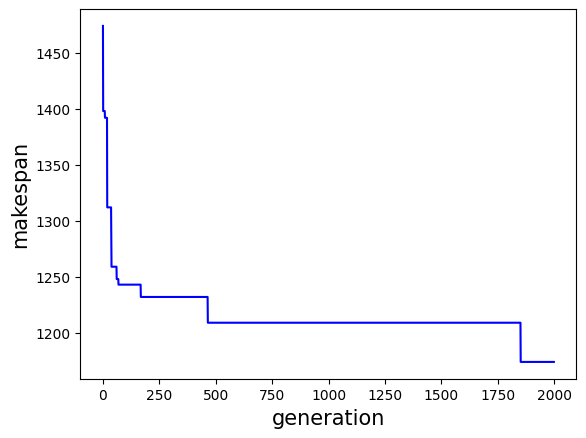

In [14]:
"""----------result----------"""
import matplotlib.pyplot as plt

print("optimal sequence", sequence_best)
print("optimal value:%f" % Tbest)
print("the elapsed time:%s" % (time.time() - start_time))


# %matplotlib inline
plt.plot([i for i in range(len(makespan_record))], makespan_record, "b")
plt.ylabel("makespan", fontsize=15)
plt.xlabel("generation", fontsize=15)
plt.show()

In [15]:
"""--------plot gantt chart-------"""
import pandas as pd
import chart_studio as cs
import chart_studio.plotly as py
import plotly.figure_factory as ff
import datetime

m_keys = [j + 1 for j in range(num_mc)]
j_keys = [j for j in range(num_job)]
key_count = {key: 0 for key in j_keys}
j_count = {key: 0 for key in j_keys}
m_count = {key: 0 for key in m_keys}
j_record = {}
for i in sequence_best:
    gen_t = int(pt[i][key_count[i]])
    gen_m = int(ms[i][key_count[i]])
    j_count[i] = j_count[i] + gen_t
    m_count[gen_m] = m_count[gen_m] + gen_t

    if m_count[gen_m] < j_count[i]:
        m_count[gen_m] = j_count[i]
    elif m_count[gen_m] > j_count[i]:
        j_count[i] = m_count[gen_m]

    start_time = str(
        datetime.timedelta(seconds=j_count[i] - pt[i][key_count[i]])
    )  # convert seconds to hours, minutes and seconds
    end_time = str(datetime.timedelta(seconds=j_count[i]))

    j_record[(i, gen_m)] = [start_time, end_time]

    key_count[i] = key_count[i] + 1


df = []
for m in m_keys:
    for j in j_keys:
        df.append(
            dict(
                Task="Machine %s" % (m),
                Start="2018-07-14 %s" % (str(j_record[(j, m)][0])),
                Finish="2018-07-14 %s" % (str(j_record[(j, m)][1])),
                Resource="Job %s" % (j + 1),
            )
        )

fig = ff.create_gantt(
    df,
    index_col="Resource",
    show_colorbar=True,
    group_tasks=True,
    showgrid_x=True,
    title="Job shop Schedule",
)
py.iplot(fig, filename="GA_job_shop_scheduling", world_readable=True)
